In [1]:
import sys
sys.path.append("../src")
import numpy as np
import nltk
from nltk.tree import Tree
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from iparse_vq import IParser
import evaluate
import torch
import torch_struct

In [2]:
# iparse = IParser("../models/en_label_gpt2_medium_cat256")
iparse = IParser("../models/32.pt")

In [3]:
dev_treebank = iparse.load_dev()

In [4]:
dev_predicted_and_cats, encoded = iparse.parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=500,
    tau=0.0,
    return_cats=True,
    return_encoded=True
)

/Users/thomas/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [5]:
rows = []
dev_trees = []
for i, (tree, cats) in enumerate(dev_predicted_and_cats):
    for (word, p), cat in zip(tree.pos(), cats):
#         p = map_tag('en-ptb', 'universal', p)
        rows.append([p, word.lower(), cat, i])
    dev_trees.append(tree)
pos_df = pd.DataFrame(rows, columns =['POS', 'Word', 'Tag', 'Sentence'])


In [6]:
used_tags = np.unique(pos_df['Tag'])

print('unused tags')
[i for i in range(iparse.parser.d_cats) if i not in used_tags]

unused tags


[]

In [7]:
def search_tag(tag):
    return pos_df[pos_df['Tag'] == tag]

In [8]:
def search_word(word):
    return pos_df[pos_df['Word'] == word.lower()].groupby(['POS', 'Tag'], as_index=False).count().sort_values(['POS', 'Tag'])

In [9]:
search_tag(31).sample(15)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
st = ' '.join(dev_predicted_and_cats[471][0].leaves())
print(st)
t, c = iparse.parse_sentence(st)
t

In [ ]:
c

In [ ]:
iparse.tree_from_cats([42, 56, 45, 36, 36, 47, 15, 43, 3, 62, 38, 22, 36, 20, 45, 45, 60, 4])

In [ ]:
def replace_leaves(tree, dummy='X'):
    leaf_treepositions = tree.treepositions('leaves')
    for i, leaf_treeposition in enumerate(leaf_treepositions):
        tree[leaf_treeposition] = dummy

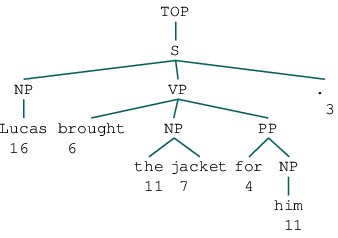

In [55]:
t, c = iparse.parse_sentence("Lucas brought the jacket for him .")
t

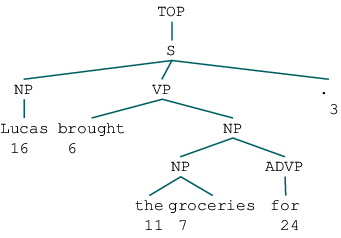

In [5]:
t, c = iparse.parse_sentence("Lucas brought the groceries for  .")
t

/Users/thomas/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


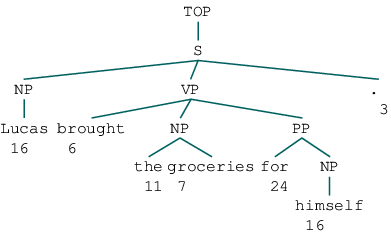

In [3]:
t, c = iparse.parse_sentence("Lucas brought the groceries for himself .")
t

In [4]:
def relabel_tree(sentence, labels):
    t, c = iparse.parse_sentence(sentence)
    assert len(labels) == len(c), 'mismatch between length of labels and tokens'
    for i, leafPos in enumerate(t.treepositions('leaves')):
        t[leafPos] = t[leafPos] + '\t\n' + str(labels[i])
    return t
    
    

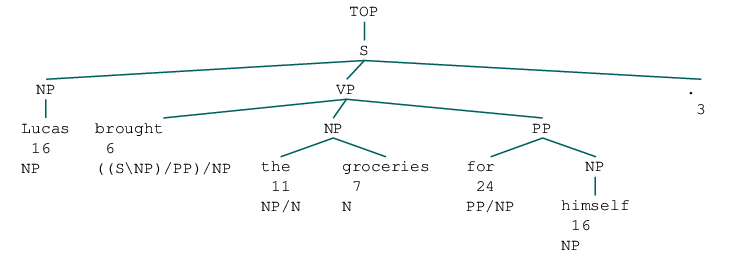

In [24]:
relabel_tree('Lucas brought the groceries for himself .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])


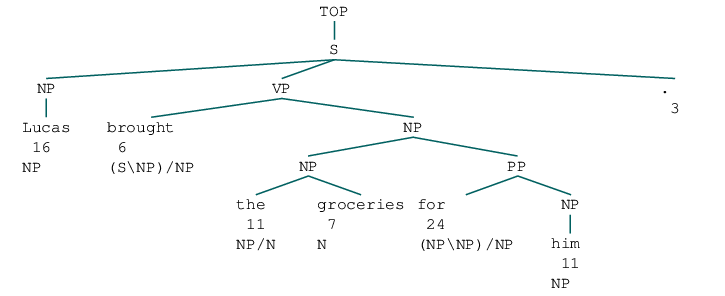

In [25]:
relabel_tree('Lucas brought the groceries for him .', ['NP', '(S\\NP)/NP', 'NP/N', 'N', '(NP\\NP)/NP', 'NP', ''])


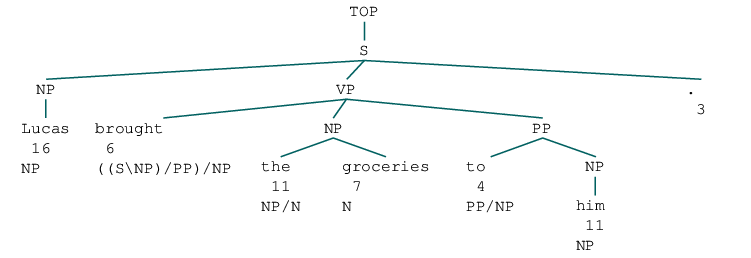

In [26]:
relabel_tree('Lucas brought the groceries to him .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])

/Users/thomas/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


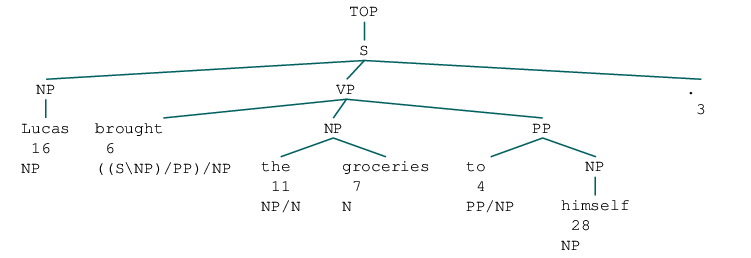

In [5]:
relabel_tree('Lucas brought the groceries to himself .', ['NP', '((S\\NP)/PP)/NP', 'NP/N', 'N', 'PP/NP', 'NP', ''])



In [12]:
c

[16, 6, 17, 11, 21, 20, 25, 3]

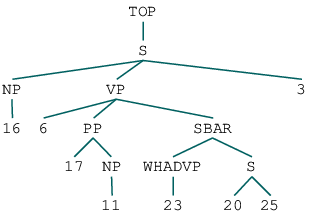

In [35]:
iparse.tree_from_cats([16, 6, 17, 11, 23, 20, 25, 3])

In [ ]:
t, c = iparse.parse_sentence("I knocked the man off his .")
t

In [ ]:
evalb_dir="../EVALB_labeled/"
dev_fscore = evaluate.evalb(
    evalb_dir, dev_treebank.trees, dev_trees)
print(dev_fscore)